In [1]:
# Load in imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import wavfile

%matplotlib inline

Read in wav file and plot the audio

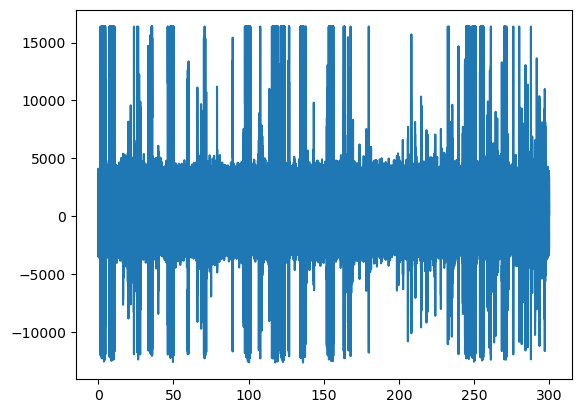

In [2]:
# Load in the wav file
fs, audio = wavfile.read('2023_03_31_7_03_30.wav')
t_song = np.arange(0, len(audio)/fs, 1/fs)

# Display the first 10 seconds of the wav file
disp_t = 300
plt.plot(t_song[:fs*disp_t], audio[:fs*disp_t])

audio_clip = audio#[:fs*disp_t]

Use spectral entropy to find start and end times

In [3]:
import SAP_features as SAP

# Get the entropy of the wav file using a sliding window
window_size = 1323
window_step = 165

sap = SAP.SAP_features(audio_clip, fs, window_size, window_step)
ent = sap.entropy
t = sap.t

c:\Users\nriveira\birdsong\SAP_features.py:39: RuntimeWarning: invalid value encountered in divide
  self.mean_freq = self.f.dot(self.sonogram**2) / np.sum(self.sonogram**2, axis=0)


Get syllable estimated start and end times

In [4]:
# Function to get the syllable start and end times based on crossing a threshold
def get_syllables(en, t, threshold, time_threshold=0.05):
    # Get the indices of the syllables
    syllable_indices = np.where(en > threshold)[0]

    sample_rate = 1/np.diff(t).mean()
    
    # Get the start and end times of the syllables, combining adjacent frames
    syllable_start = [t[syllable_indices[0]]]
    syllable_end = []

    for i in range(len(syllable_indices)-1):
        if syllable_indices[i+1] - syllable_indices[i] > 1:
            syllable_end.append(t[syllable_indices[i]])
            syllable_start.append(t[syllable_indices[i+1]])

    syllable_end.append(t[syllable_indices[-1]])

    syllable_start_arr = np.array(syllable_start)
    syllable_end_arr = np.array(syllable_end)
    duration = syllable_end_arr-syllable_start_arr

    return syllable_start_arr[duration > time_threshold], syllable_end_arr[duration > time_threshold]

# Get the syllable start and end times
syllable_start, syllable_end = get_syllables(ent, t, 0.2)

(0.0, 5.0)

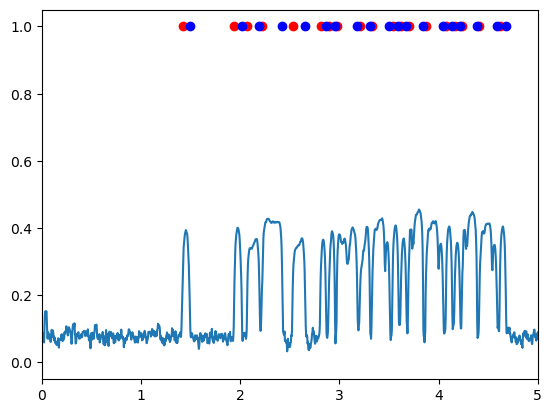

In [5]:
# Plot the start and end times on top of the entropy
plt.plot(t, ent)
plt.plot(syllable_start, np.ones(len(syllable_start)), 'ro')
plt.plot(syllable_end, np.ones(len(syllable_end)), 'bo')
plt.xlim([0, 5])

Create syllable dataframe

In [10]:
# Make a dataframe of the syllable audio and start and end times
syllables = pd.DataFrame(columns=['start', 'end', 'audio', 'sonogram', 'spectral_derivative'])
syllable_min = np.floor(min(syllable_end-syllable_start)*fs).astype(int)
syllable_bin_min = np.floor(syllable_min/window_step).astype(int)
print("Minimum syllable length: {} samples".format(syllable_min))
print("Number of time bins per syllable sample: {}".format(syllable_bin_min))
print("Number of syllables detected: {}".format(len(syllable_start)))

# Makes a struct of all syllables first 50 ms 
# Can also be modified to include the whole syllable, but only the first 50 ms are used here
for i in range(len(syllable_start)):
    start_s = syllable_start[i] # returns time in seconds
    start = np.searchsorted(t_song, start_s)
    start_fft = np.searchsorted(t, start_s)
    
    sono = sap.sonogram[:,start_fft:start_fft+syllable_bin_min]
    dSono = sap.spectral_derivative[:,start_fft:start_fft+syllable_bin_min]    

    end_s = syllable_end[i] # returns time in seconds
    end = np.searchsorted(t_song, end_s)

    # audio_syl = audio[start:end]
    audio_syl = audio[start:start+syllable_min]

    syllables.loc[i] = [start_s, end_s, audio_syl, sono, dSono]

# make all syllables the same length
# max_length = syllables['audio'].apply(len).max()
# syllables['audio'] = syllables['audio'].apply(lambda x: np.pad(x, (0, max_length-len(x)), 'constant'))

Minimum syllable length: 2309 samples
Number of time bins per syllable sample: 13
Number of syllables detected: 3253


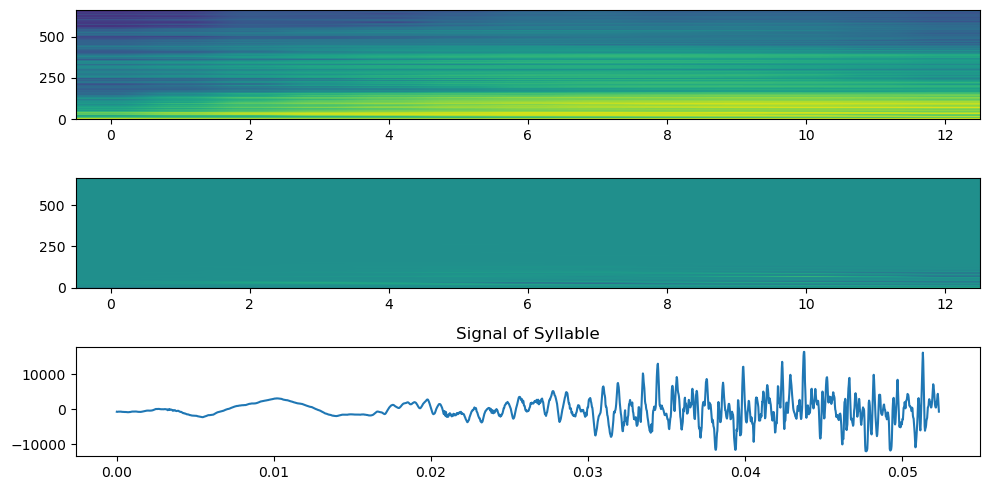

In [11]:
# Play first syllable
from IPython.display import Audio
syll = 0

# Plot spectrogram (in dB) and signal of first syllable
plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.imshow(np.log(syllables.sonogram[syll]), aspect='auto', origin='lower')
plt.subplot(312)
plt.imshow(syllables.spectral_derivative[syll], aspect='auto', origin='lower')
plt.subplot(313)
plt.plot(np.arange(syllable_min)/fs, syllables.audio[syll])
plt.title('Signal of Syllable')
plt.tight_layout()

Audio(syllables.audio[syll], rate=fs)

Save pandas structure to use librosa features in another environment

In [12]:
syllables.to_pickle('syllables.pkl')
syllables.head()

,start,end,audio,sonogram,spectral_derivative
0,1.418027,1.489116,"[-714, -742, -718, -702, -686, -682, -661, -66...","[[423641452.5512427, 302242973.2266859, 193954...","[[-5.863181637567577e-05, -0.00049998514597368..."
1,1.941837,2.012925,"[-1019, -985, -987, -967, -935, -905, -901, -8...","[[537691182.1141583, 419277547.2556464, 445570...","[[0.00022787008102809818, 0.002986790259529341..."
2,2.072789,2.192517,"[-451, -505, -489, -493, -560, -606, -652, -70...","[[1530968335.4681425, 1564288654.7873232, 1528...","[[0.009005660988438852, 0.009552646049950526, ..."
3,2.218707,2.424490,"[-1615, -1805, -1930, -2076, -2090, -2398, -24...","[[574061913.8935981, 422403563.7620248, 276044...","[[-0.0010127593016708313, -0.00208765962042781..."
4,2.529252,2.652721,"[1958, 1969, 2001, 2000, 1971, 1979, 1975, 195...","[[979990962.2180833, 1136811010.452191, 122036...","[[0.008527323381278578, 0.006273124371225765, ..."
